In [10]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm
import sys

sys.path.append('/private/groups/shapirolab/brock/Software')
from py3_functions import *

from IPython.display import display

!mkdir -p /private/groups/shapirolab/brock/mutation
os.chdir('/private/groups/shapirolab/brock/mutation')
!mkdir -p cmds logs

### R stuff
from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

samples = []
with open('poplists/samples.txt') as infile:
    for line in infile:
        line = line.strip()
        samples.append(line)
infile.close()

chroms = []
with open('white_abalone.fasta.fai','r') as infile:
    for line in infile:
        chrom, size, total, b, c = line.split('\t')
        if int(size) > 1e6:
            chroms.append(chrom)
infile.close()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
%%R
library(ggplot2)
library(tidyverse)
library(magrittr)
library(data.table)

# Deep sequencing QC

## Lane-level raw QC

In [11]:
import glob
R1 = glob.glob('raw/*R1*')
R2 = glob.glob('raw/*R2*')
fs = R1 + R2
for ix,FILE in enumerate(fs):
    cmd = ('''/private/groups/shapirolab/brock/Software/FastQC/fastqc {FILE} -o raw''').format(FILE = FILE)
    slurm = make_slurm(run = True, id = f"{ix}.fastqc",cmd_string = cmd, mem = '5000',time='24:00:00',p = 'long')

Submitted batch job 3608044
Submitted batch job 3608045
Submitted batch job 3608046
Submitted batch job 3608047
Submitted batch job 3608048
Submitted batch job 3608049
Submitted batch job 3608050
Submitted batch job 3608051


Examine with multiqc report

## Fastp

In [10]:
import glob
!mkdir -p raw/fastp/
fs = glob.glob('raw/*R1*gz')
for ix,R1 in enumerate(fs):
    R2 = re.sub('R1','R2',R1)
    OUT1 = re.sub('raw/','raw/fastp/',R1)
    OUT2 = re.sub('raw/','raw/fastp/',R2)
    UP1 = re.sub('.fastq.gz','_unpaired.fastq.gz',OUT1)
    UP2 = re.sub('.fastq.gz','_unpaired.fastq.gz',OUT2)
    cmd = f"fastp -V --in1 {R1} --in2 {R2} --out1 {OUT1} --out2 {OUT2} --unpaired1 {UP1} --unpaired2 {UP2} "
    slurm = make_slurm(run = True, id = f"{ix}.fastp",cmd_string = cmd, mem = '25000',time='24:00:00',p = 'long')

Submitted batch job 3607749
Submitted batch job 3607750
Submitted batch job 3607751
Submitted batch job 3607752


## Post-fastp

In [15]:
R1 = glob.glob('data/fastp/*R1*')
R2 = glob.glob('data/fastp/*R2*')
fs = R1 + R2
for ix,FILE in enumerate(fs):
    if 'unpaired' in FILE: continue
    cmd = ('''/private/groups/shapirolab/brock/Software/FastQC/fastqc {FILE} -o data/fastp/''').format(FILE = FILE)
    slurm = make_slurm(id = f"{ix}.fastqc",cmd_string = cmd, mem = '5000',time='24:00:00',p = 'long')

## Merge fastq files

In [25]:
!mkdir -p data/merged
samples_2_fastp = {}
with open('poplists/samples_2_fastp.txt','r') as infile:
    for line in infile:
        line = line.strip()
        sample,path = line.split('\t')
        if sample in samples_2_fastp.keys():
            if 'R1' in path:
                samples_2_fastp[sample]['R1'].append(path)
            else:
                samples_2_fastp[sample]['R2'].append(path)
        else:
            if 'R1' in path:
                samples_2_fastp[sample] = {'R1':[path],'R2':[]}
            else:
                samples_2_fastp[sample] = {'R1':[],'R2':[path]}
infile.close()
for sample, fs in samples_2_fastp.items():
    for read_set,files in samples_2_fastp[sample].items():
        file_string = ' '.join(files)
        merge_cmd = f"cat {file_string} > data/merged/{sample}_{read_set}.fastq.gz"
        slurm = make_slurm(run = True, id=f"{sample}_{read_set}_merge",cmd_string = merge_cmd, mem='30000',time = '12:00:00', p = 'long')

Submitted batch job 3254276
Submitted batch job 3254277
Submitted batch job 3254278
Submitted batch job 3254279
Submitted batch job 3254280
Submitted batch job 3254281
Submitted batch job 3254282
Submitted batch job 3254283
Submitted batch job 3254284
Submitted batch job 3254285
Submitted batch job 3254286
Submitted batch job 3254287
Submitted batch job 3254288
Submitted batch job 3254289
Submitted batch job 3254290
Submitted batch job 3254291
Submitted batch job 3254292
Submitted batch job 3254293
Submitted batch job 3254294
Submitted batch job 3254295
Submitted batch job 3254296
Submitted batch job 3254297
Submitted batch job 3254298
Submitted batch job 3254299
Submitted batch job 3254300
Submitted batch job 3254301
Submitted batch job 3254302
Submitted batch job 3254303


# Alignment

In [17]:
RAWDIR = 'raw/fastp/'
WORKDIR = 'raw/aln'
refgenome = 'white_abalone.fasta'
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/abalone/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'

samples = []
with open('poplists/samples.txt') as infile:
    for line in infile:
        line = line.strip()
        samples.append(line)
infile.close()

for SAMP in ['NorbertW756','NorbertW802','Y121']:
    # Alignment
    R1 = [x for x in glob.glob(f"raw/fastp/{SAMP}*R1*gz") if 'unpaired' not in x][0]
    R2 = [x for x in glob.glob(f"raw/fastp/{SAMP}*R2*gz") if 'unpaired' not in x][0]
    aln_1 = ('''if [[ ! -f {WORKDIR}/{SAMP}.bam.bai ]];then '''
            '''{s_lic} {s_temp}'''
           '''({s_exec} '''
           '''bwa mem -R \'@RG\\tID:{SAMP}\\tSM:{SAMP}\\tPL:ILLUMINA\' '''
           '''-aM -t 16 {refgenome} {R1} {R2} '''
           '''|| echo -n \'error\') | '''
           '''{s_exec} util sort -r {refgenome} -o {WORKDIR}/{SAMP}.bam --sam2bam -i -;fi \n\n\n\n''').format(R1 = R1, R2 = R2, RAWDIR = RAWDIR, s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, s_temp = s_temp, WORKDIR = WORKDIR, SAMP = SAMP)
    
    dups_p1 = ('''{s_lic} {s_temp}'''
               '''{s_exec} '''
               '''driver -i {WORKDIR}/{SAMP}.bam --algo LocusCollector --fun score_info {WORKDIR}/{SAMP}_SCORE.gz\n'''
               '''\n\n\n''').format(s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, WORKDIR = WORKDIR, SAMP = SAMP, s_temp = s_temp)
    
    dups_p2 = ('''echo -e "Dups p1. completed\\n\\n";'''
               '''{s_exec} '''
               '''driver -i {WORKDIR}/{SAMP}.bam --algo Dedup --score_info {WORKDIR}/{SAMP}_SCORE.gz '''
               '''--metrics {WORKDIR}/{SAMP}.metrics.txt {WORKDIR}/{SAMP}.mdup.bam\n'''
               '''\n\n\n''').format(s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, WORKDIR = WORKDIR, s_temp = s_temp, SAMP = SAMP)
    
    
    ## Min Qual, RM DUP
    proc_cmd = ('''samtools view -q 20 -b {WORKDIR}/{SAMP}.mdup.bam | '''
                '''samtools sort | '''
                '''samtools rmdup - {WORKDIR}/{SAMP}.qF.bam\n\n\n''').format(SAMP = SAMP, WORKDIR = WORKDIR)
    
    
    ## FLAGSTAT
    stat_cmd = ('''samtools flagstat {WORKDIR}/{SAMP}.mdup.bam > {WORKDIR}/{SAMP}.filt.stats.txt\n'''
                '''samtools flagstat {WORKDIR}/{SAMP}.qF.bam > {WORKDIR}/{SAMP}.filt.qF.stats.txt\n\n\n''').format(WORKDIR = WORKDIR, SAMP = SAMP)
    
    full_cmd = aln_1 + dups_p1 + dups_p2 + proc_cmd + stat_cmd
    #outfile = open(f"cmds/{SAMP}.aln.sh",'w')
    #outfile.write('#!/bin/bash\n')
    #outfile.write(full_cmd)
    #outfile.close()
    slurm = make_slurm(run = True, id = f"{SAMP}.aln", cmd_string = full_cmd, mem = '120000', time = '48:00:00', p = 'long',c=16)

Submitted batch job 3609234
Submitted batch job 3609235
Submitted batch job 3609236


In [29]:
%%R
fs = list.files('aln/','metrics.txt', full.names = T)
dfs = lapply(fs, function(PATH){fread(PATH,skip = 1, nrows = 2) %>% mutate(sample = basename(PATH) %>% gsub('.metrics.txt','',.))})
reports = bind_rows(dfs)
reports %>% dplyr::select(!LIBRARY) %>% relocate(sample) %>%
fwrite('post_QC_alignment_sample_level_report.csv')

## Merge new runs with old

In [20]:
for SAMP in ['NorbertW756','NorbertW802','Y121']:
    oldbam = f"aln/{SAMP}.mdup.bam"
    newbam = f"raw/aln/{SAMP}.mdup.bam"
    cmd = f"sambamba merge -t 32 aln/{SAMP}.combined.mdup.bam {oldbam} {newbam}"
    slurm = make_slurm(run = True, c = 32, p = 'long', id = f"{SAMP}.merge", cmd_string = cmd, mem = '60000', time = '24:00:00')

Submitted batch job 3614785
Submitted batch job 3614786
Submitted batch job 3614787


# Variant calling

## Haplotype caller

In [22]:
### PATHS ###
refgenome = 'white_abalone.fasta'
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/abalone/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'

!mkdir -p gvcfs

samples = []
with open('poplists/samples.txt') as infile:
    for line in infile:
        line = line.strip()
        samples.append(line)
infile.close()

### GENERATE CMDS ###
#for sample, data in complete.items():
for sample in ['NorbertW756','NorbertW802','Y121']:
    bam = f"aln/{sample}.combined.mdup.bam"
    if not os.path.exists(bam + ".bai"): continue
    ##
    haplo_cmd = ('''{s_lic} {s_temp}'''
                 '''{s_exec} '''
                 '''driver -t 32 -r {refgenome} -i {bam} '''
                 '''--algo Haplotyper --emit_mode gvcf '''
                 '''gvcfs/{sample}.gvcf.gz\n''').format(bam = bam, sample = sample, refgenome = refgenome, s_lic = s_lic, s_temp = s_temp, s_exec = s_exec)
    make_slurm(run = True, id = f"{sample}.hapcal",cmd_string = haplo_cmd, mem = '100000',c = 32, p = 'long', time = '12:00:00')

Submitted batch job 3614861
Submitted batch job 3614862
Submitted batch job 3614863


## Joint genotyping

In [24]:
### PATHS ###
brockdir = "/private/groups/shapirolab/brock"
refgenome = 'white_abalone.fasta'
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/abalone/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'

!mkdir -p vcfs

gvcf_string = ''
infile = open('poplists/samples.txt','r')
for line in infile:
    line = line.strip('\n')
    sample = line.split('\t')[0]
    gvcf_string += f"-v gvcfs/{sample}.gvcf.gz "
infile.close()

chroms = []
with open('white_abalone.fasta.fai','r') as infile:
    for line in infile:
        chrom, size, total, b, c = line.split('\t')
        if int(size) > 1e6:
            chroms.append(chrom)
infile.close()


!mkdir -p vcfs
for CHROM in chroms:
    joint_cmd = ('''{s_lic} {s_temp}'''
                 '''{s_exec} '''
                 '''driver -t 8 -r {refgenome} --interval {CHROM} --algo GVCFtyper '''
                 '''{gvcf_string} '''
                 '''--emit_mode ALL '''
                 '''vcfs/{CHROM}.allsites.anno.vcf.gz\n''').format(CHROM = CHROM, s_temp = s_temp, s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, gvcf_string = gvcf_string)
    slurm = make_slurm(run = True, id = f"{CHROM}.joint",p = 'long', cmd_string =  joint_cmd, mem = '40000',time='04:00:00', c=8)

Submitted batch job 3621550
Submitted batch job 3621551
Submitted batch job 3621552
Submitted batch job 3621553
Submitted batch job 3621554
Submitted batch job 3621555
Submitted batch job 3621556
Submitted batch job 3621557
Submitted batch job 3621558
Submitted batch job 3621559
Submitted batch job 3621560
Submitted batch job 3621561
Submitted batch job 3621562
Submitted batch job 3621563
Submitted batch job 3621564
Submitted batch job 3621565
Submitted batch job 3621566
Submitted batch job 3621567


## Filter

In [ ]:
for CHROM in chroms:
    cmd = ('''singularity exec --bind /private/groups/shapirolab/brock/mutation/ /private/groups/shapirolab/brock/Software/gatk.sif '''
           '''gatk VariantFiltration '''
           '''-R white_abalone.fasta '''
           '''-V vcfs/{CHROM}.allsites.anno.vcf.gz '''
           '''--output vcfs/{CHROM}.filtered.vcf.gz '''
           '''--filter-name \"RPRS_filter\" --filter-expression \"(vc.isSNP() && (vc.hasAttribute('ReadPosRankSum') && ReadPosRankSum < -8.0)) || ((vc.isIndel() || vc.isMixed()) && (vc.hasAttribute('ReadPosRankSum') && ReadPosRankSum < -20.0)) || (vc.hasAttribute('QD') && QD < 2.0)\" '''
           '''--filter-name \"FS_SOR_filter\" --filter-expression \"(vc.isSNP() && ((vc.hasAttribute('FS') && FS > 60.0) || (vc.hasAttribute('SOR') &&  SOR > 3.0))) || ((vc.isIndel() || vc.isMixed()) && ((vc.hasAttribute('FS') && FS > 200.0) || (vc.hasAttribute('SOR') &&  SOR > 10.0)))\" '''
           '''--filter-name \"MQ_filter\" --filter-expression \"vc.isSNP() && ((vc.hasAttribute('MQ') && MQ < 40.0) || (vc.hasAttribute('MQRankSum') && MQRankSum < -12.5))\" '''
           '''--filter-name \"QUAL_filter\" --filter-expression \"QUAL < 30.0\" '''
           '''--invalidate-previous-filters true && tabix -f vcfs/{CHROM}.filtered.vcf.gz\n''').format(CHROM = CHROM)
    slurm = make_slurm(run = True, id = f"{CHROM}.filter",cmd_string = cmd, mem = '20000',time='12:00:00',p = 'long')

Biallelic SNPs only

In [33]:
for CHROM in chroms:
    cmd = ('''bcftools view -f .,PASS --min-ac 1:minor -M2 -m2 -v snps -O z -o vcfs/{CHROM}.biallelic.vcf.gz vcfs/{CHROM}.filtered.vcf.gz && tabix -f vcfs/{CHROM}.biallelic.vcf.gz''').format(CHROM = CHROM)
    slurm = make_slurm(run = True, id = f"{CHROM}.f2",cmd_string = cmd, mem = '2000',time='02:00:00',p = 'long')

Submitted batch job 3622927
Submitted batch job 3622928
Submitted batch job 3622929
Submitted batch job 3622930
Submitted batch job 3622931
Submitted batch job 3622932
Submitted batch job 3622933
Submitted batch job 3622934
Submitted batch job 3622935
Submitted batch job 3622936
Submitted batch job 3622937
Submitted batch job 3622938
Submitted batch job 3622939
Submitted batch job 3622940
Submitted batch job 3622941
Submitted batch job 3622942
Submitted batch job 3622943
Submitted batch job 3622944


 Concatenate

In [34]:
catcmd = 'bcftools concat -O z -o vcfs/biallelic.vcf.gz '
for CHROM in chroms:
    catcmd += f"vcfs/{CHROM}.biallelic.vcf.gz "
!$catcmd

Checking the headers and starting positions of 18 files
Concatenating vcfs/HiC_scaffold_1.biallelic.vcf.gz	7.345652 seconds
Concatenating vcfs/HiC_scaffold_2.biallelic.vcf.gz	7.339956 seconds
Concatenating vcfs/HiC_scaffold_3.biallelic.vcf.gz	8.163727 seconds
Concatenating vcfs/HiC_scaffold_4.biallelic.vcf.gz	5.724639 seconds
Concatenating vcfs/HiC_scaffold_5.biallelic.vcf.gz	7.950954 seconds
Concatenating vcfs/HiC_scaffold_6.biallelic.vcf.gz	8.541173 seconds
Concatenating vcfs/HiC_scaffold_7.biallelic.vcf.gz	12.376075 seconds
Concatenating vcfs/HiC_scaffold_8.biallelic.vcf.gz	5.467320 seconds
Concatenating vcfs/HiC_scaffold_9.biallelic.vcf.gz	6.620409 seconds
Concatenating vcfs/HiC_scaffold_10.biallelic.vcf.gz	6.651716 seconds
Concatenating vcfs/HiC_scaffold_11.biallelic.vcf.gz	6.750209 seconds
Concatenating vcfs/HiC_scaffold_12.biallelic.vcf.gz	13.368748 seconds
Concatenating vcfs/HiC_scaffold_13.biallelic.vcf.gz	6.676979 seconds
Concatenating vcfs/HiC_scaffold_14.biallelic.vcf.gz	5.

# Bcftools version

In [30]:
brockdir = "/private/groups/shapirolab/brock"
refgenome = 'white_abalone.fasta'

!mkdir -p vcfs

bam_string = ''
infile = open('poplists/samples.txt','r')
for line in infile:
    line = line.strip('\n')
    sample = line.split('\t')[0]
    if sample in ['NorbertW756','NorbertW802','Y121']:
        bam_string += f"aln/{sample}.combined.mdup.bam "
    else:
        bam_string += f"aln/{sample}.mdup.bam "
infile.close()

chroms = []
with open('white_abalone.fasta.fai','r') as infile:
    for line in infile:
        chrom, size, total, b, c = line.split('\t')
        if int(size) > 1e6:
            chroms.append(chrom)
infile.close()

!mkdir -p bcftools
for CHROM in chroms:
    cmd = ('''bcftools mpileup --annotate FORMAT/AD,FORMAT/ADF,FORMAT/ADR,FORMAT/DP,FORMAT/SP,INFO/AD,INFO/ADF,INFO/ADR --min-MQ 20 --min-BQ 20 --max-depth 500 -Ou -r {CHROM} -f {refgenome} --threads 16 {bam_string}| '''
           '''bcftools call --threads 16 -m --ploidy 2 -Oz -o bcftools/{CHROM}.allsites.vcf.gz && tabix -f bcftools/{CHROM}.allsites.vcf.gz\n''').format(CHROM = CHROM, refgenome = refgenome, bam_string = bam_string)
    slurm = make_slurm(run = True, id = f"{CHROM}.bcftools", cmd_string = cmd, mem = '80000', time = '48:00:00', c = '16', p = 'long')


Submitted batch job 3621622
Submitted batch job 3621623
Submitted batch job 3621624
Submitted batch job 3621625
Submitted batch job 3621626
Submitted batch job 3621627
Submitted batch job 3621628
Submitted batch job 3621629
Submitted batch job 3621630
Submitted batch job 3621631
Submitted batch job 3621632
Submitted batch job 3621633
Submitted batch job 3621634
Submitted batch job 3621635
Submitted batch job 3621636
Submitted batch job 3621637
Submitted batch job 3621638
Submitted batch job 3621639


## Filter these as well

In [31]:
chroms = []
with open('white_abalone.fasta.fai','r') as infile:
    for line in infile:
        chrom, size, total, b, c = line.split('\t')
        if int(size) > 1e6:
            chroms.append(chrom)
infile.close()

for CHROM in chroms:
    cmd = ('''singularity exec --bind /private/groups/shapirolab/brock/mutation/ /private/groups/shapirolab/brock/Software/gatk.sif '''
           '''gatk VariantFiltration '''
           '''-R white_abalone.fasta '''
           '''-V bcftools/{CHROM}.allsites.vcf.gz '''
           '''--output bcftools/{CHROM}.filtered.vcf.gz '''
           '''--filter-name \"FS_SOR_filter\" --filter-expression \"(vc.isSNP() && ((vc.hasAttribute('FS') && FS > 60.0) || (vc.hasAttribute('SOR') &&  SOR > 3.0))) || ((vc.isIndel() || vc.isMixed()) && ((vc.hasAttribute('FS') && FS > 200.0) || (vc.hasAttribute('SOR') &&  SOR > 10.0)))\" '''
           #'''--filter-name \"FS_SOR_filter\" --filter-expression \"((vc.isSNP() && (vc.hasAttribute('FS') && FS > 60.0)) || ((vc.isIndel() || vc.isMixed()) && (vc.hasAttribute('FS') && FS > 200.0))\" '''
           '''--filter-name \"MQ_filter\" --filter-expression \"vc.isSNP() && ((vc.hasAttribute('MQ') && MQ < 40.0))\" '''
           '''--filter-name \"QUAL_filter\" --filter-expression \"QUAL < 30.0\" '''
           '''--invalidate-previous-filters true && tabix -f bcftools/{CHROM}.filtered.vcf.gz\n''').format(CHROM = CHROM)
    slurm = make_slurm(run = True, id = f"{CHROM}.filter",cmd_string = cmd, mem = '20000',time='12:00:00',p = 'long')

Submitted batch job 3622909
Submitted batch job 3622910
Submitted batch job 3622911
Submitted batch job 3622912
Submitted batch job 3622913
Submitted batch job 3622914
Submitted batch job 3622915
Submitted batch job 3622916
Submitted batch job 3622917
Submitted batch job 3622918
Submitted batch job 3622919
Submitted batch job 3622920
Submitted batch job 3622921
Submitted batch job 3622922
Submitted batch job 3622923
Submitted batch job 3622924
Submitted batch job 3622925
Submitted batch job 3622926


Biallelic SNPs only

In [35]:
for CHROM in chroms:
    cmd = ('''bcftools view -f .,PASS --min-ac 1:minor -M2 -m2 -O z -o bcftools/{CHROM}.biallelic.vcf.gz bcftools/{CHROM}.filtered.vcf.gz && tabix -f bcftools/{CHROM}.biallelic.vcf.gz\n''').format(CHROM = CHROM)
    slurm = make_slurm(run = True, id = f"{CHROM}.f2",cmd_string = cmd, mem = '2000',time='02:00:00',p = 'long')

Submitted batch job 3622973
Submitted batch job 3622974
Submitted batch job 3622975
Submitted batch job 3622976
Submitted batch job 3622977
Submitted batch job 3622978
Submitted batch job 3622979
Submitted batch job 3622980
Submitted batch job 3622981
Submitted batch job 3622982
Submitted batch job 3622983
Submitted batch job 3622984
Submitted batch job 3622985
Submitted batch job 3622986
Submitted batch job 3622987
Submitted batch job 3622988
Submitted batch job 3622989
Submitted batch job 3622990


In [37]:
catcmd = 'bcftools concat -O z -o bcftools/biallelic.vcf.gz '
for CHROM in chroms:
    catcmd += f"bcftools/{CHROM}.biallelic.vcf.gz "
!$catcmd

Checking the headers and starting positions of 18 files
Concatenating bcftools/HiC_scaffold_1.biallelic.vcf.gz	16.706196 seconds
Concatenating bcftools/HiC_scaffold_2.biallelic.vcf.gz	16.190239 seconds
Concatenating bcftools/HiC_scaffold_3.biallelic.vcf.gz	17.613143 seconds
Concatenating bcftools/HiC_scaffold_4.biallelic.vcf.gz	12.951040 seconds
Concatenating bcftools/HiC_scaffold_5.biallelic.vcf.gz	17.032409 seconds
Concatenating bcftools/HiC_scaffold_6.biallelic.vcf.gz	18.366842 seconds
Concatenating bcftools/HiC_scaffold_7.biallelic.vcf.gz	25.466396 seconds
Concatenating bcftools/HiC_scaffold_8.biallelic.vcf.gz	12.220690 seconds
Concatenating bcftools/HiC_scaffold_9.biallelic.vcf.gz	14.557024 seconds
Concatenating bcftools/HiC_scaffold_10.biallelic.vcf.gz	14.752338 seconds
Concatenating bcftools/HiC_scaffold_11.biallelic.vcf.gz	14.589281 seconds
Concatenating bcftools/HiC_scaffold_12.biallelic.vcf.gz	28.271542 seconds
Concatenating bcftools/HiC_scaffold_13.biallelic.vcf.gz	14.628276

# Kinship matrix

In [107]:
## plink2 already in bin
cmd = 'plink2 --vcf vcfs/biallelic.vcf.gz --make-king square --allow-extra-chr --out white_ab_kin'
print(cmd)

plink2 --vcf vcfs/biallelic.vcf.gz --make-king square --allow-extra-chr --out white_ab_kin


In [5]:
%%R
ids = fread('white_ab_kin.king.id')[,1] %>% pull(1)
r = fread('white_ab_kin.king')
ord <- hclust( dist(r, method = "euclidean"), method = "ward.D" )$order
ord = ids[ord]
r %<>% 
    set_colnames(c(ids)) %>%
    mutate(sample = ids) %>%
    pivot_longer(-c(sample)) %>%
    rowwise() %>%
    mutate(pair = sort(c(sample, name)) %>% paste(collapse = ",")) %>%
    group_by(pair) %>%
    distinct(pair, .keep_all = T)
head(r)

# A tibble: 6 × 4
# Groups:   pair [6]
  sample name     value pair           
  <chr>  <chr>    <dbl> <chr>          
1 BML309 BML309   0.5   BML309,BML309  
2 BML309 BML397   0.217 BML309,BML397  
3 BML309 FG29     0.126 BML309,FG29    
4 BML309 FG30     0.112 BML309,FG30    
5 BML309 FG33     0.129 BML309,FG33    
6 BML309 Green312 0.113 BML309,Green312


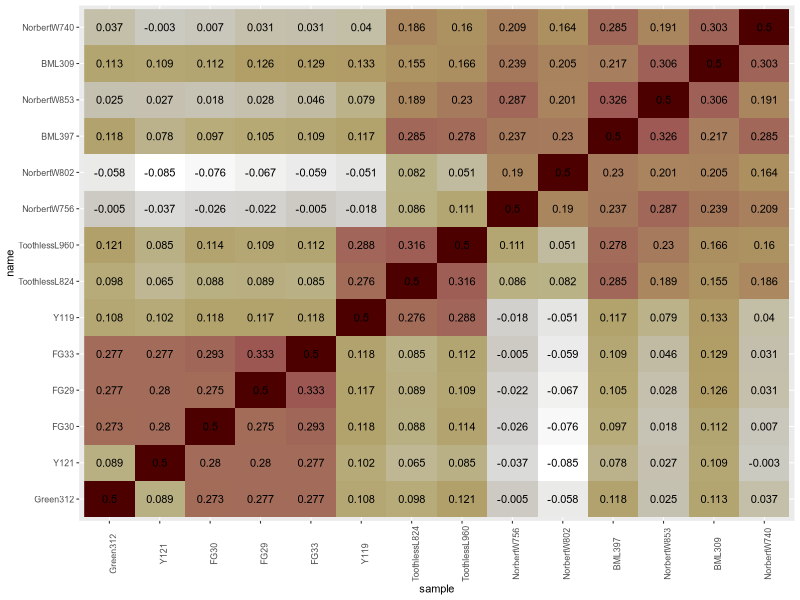

In [7]:
%%R -w 800 -h 600
ids = fread('white_ab_kin.king.id')[,1] %>% pull(1)
r = fread('white_ab_kin.king')
ord <- hclust( dist(r, method = "euclidean"), method = "ward.D" )$order
ord = ids[ord]
r %<>% 
    set_colnames(c(ids)) %>%
    mutate(sample = ids) %>%
    pivot_longer(-c(sample)) #%>%
    #rowwise() %>%
    #mutate(pair = sort(c(sample, name)) %>% paste(collapse = ",")) %>%
    #group_by(pair) %>%
    #distinct(pair, .keep_all = T)
r$sample = factor(r$sample, levels = ord)
r$name = factor(r$name, levels = ord)

library(scico)
p = ggplot(r) +
    geom_raster(aes(x = sample, y = name, fill = value)) +
    geom_text(aes(x = sample, y = name, label = round(value,3))) +
    scico::scale_fill_scico(palette = "bilbao", direction = -1) +

    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')

print(p)
ggsave('./mutation_figs/kinship.pdf', width = 6, height = 6)

In [112]:
%%R
r %>% filter(sample == 'BML309') %>% arrange(desc(value))

# A tibble: 14 × 3
   sample name          value
   <fct>  <fct>         <dbl>
 1 BML309 BML309        0.5  
 2 BML309 NorbertW853   0.306
 3 BML309 NorbertW740   0.303
 4 BML309 NorbertW756   0.239
 5 BML309 BML397        0.217
 6 BML309 NorbertW802   0.205
 7 BML309 ToothlessL960 0.166
 8 BML309 ToothlessL824 0.155
 9 BML309 Y119          0.133
10 BML309 FG33          0.129
11 BML309 FG29          0.126
12 BML309 Green312      0.113
13 BML309 FG30          0.112
14 BML309 Y121          0.109


In [8]:
%%R
r = fread('depth/BML309_bad_sites.txt')

R[write to console]: |--------------------------------------------------|
|
R[write to console]: ==
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: =
R[write to console]: =
R[write to console]: ==
R[write to console]: |



In [ ]:
%%R -w 1200 -h 400
ggplot(r %>% filter(V1 == 'HiC_scaffold_18')) +
    geom_bar(aes(x=V2,y=V3),stat='identity') +
    coord_cartesian(ylim=c(0,19))

In [ ]:
%%R -w 1200 -h 400
ggplot(r %>% filter(V1 == 'HiC_scaffold_1')) +
    geom_bar(aes(x=V2,y=V3),stat='identity') +
    coord_cartesian(ylim=c(0,19))